## Vehicle Detection Project Writeup

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [40]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.ndimage as snd
from skimage.feature import hog
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
import pickle

%matplotlib inline

cars = glob.glob('resources/vehicles/**/*.png')
notcars = glob.glob('resources/non-vehicles/**/*.png')

### Histogram of Oriented Gradients (HOG)

I used following functions to extract features such as:

* spatial feature
* histogram feature
* HOG features

I tried them spererately but the classifier trained with them was not able to perform well on the project
video. Only after combining them together I received satisfying result.

In [15]:
def get_spatial_features(img, spatial_size=(32, 32)):
    features = cv2.resize(img, spatial_size).ravel() 
    return features
 
def get_histogram_features(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)

    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In order to decied which parameters use to extract HOG features I took random car and not car image:

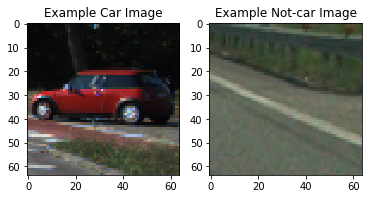

In [19]:
rand_car_ind = np.random.randint(0, len(cars))
rand_notcar_ind = np.random.randint(0, len(notcars))

example_car = snd.imread(cars[rand_car_ind])
example_notcar = snd.imread(notcars[rand_notcar_ind])

plt.subplot(121)
plt.imshow(example_car)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(example_notcar)
plt.title('Example Not-car Image')

>**CRITERIA:** Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.

and tried different combination of parameters (colorspace,orientations,pixels_per_cell, cells_per_block) given to **hog_image()** function which actually extracts HOG features. Here is an example of gray colorspace and a few
different values for colorspace,orientations,pixels_per_cell, cells_per_block params:

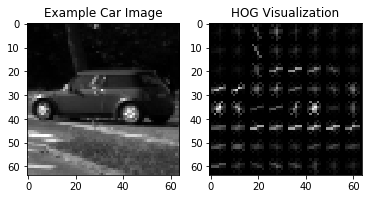

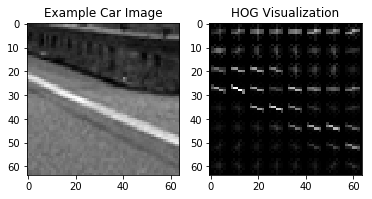

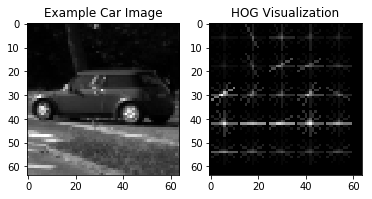

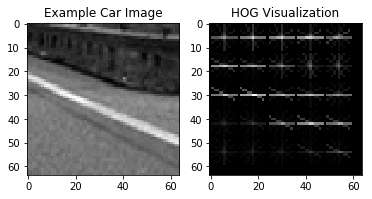

In [20]:
def visualize_hog(img, orientations, pixels_per_cell, cells_per_block):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, orientations, pixels_per_cell, cells_per_block, True, False)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(gray, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')
    
visualize_hog(example_car, 9, 8, 2)
visualize_hog(example_notcar, 9, 8, 2)

visualize_hog(example_car, 6, 12, 4)
visualize_hog(example_notcar, 6, 12, 4)

I decided to stick with the default values from lectures for orientation, pixels_per_cell, cells_per_block params (9,8,2 correspondingly) because they gave me the best accuracy on test set (after training a LinearSVC) and best
results on cars finding in project video. By using the same prcedure of taking what gives best accuracy on train set and on project video I choose YCrCb colorspace and spatial size=(32,32) together with number of bins=32. By
best accuracy on project video I mean lowest value of false positives and higher number of detections for cars.

In [21]:
SPATIAL_SIZE = (32, 32)
NBINS = 32
COLORSPACE = 'YCrCb'
ORIENT = 9
PIX_PER_CELL = 8
CELL_PER_BLOCK = 2
HOG_CHANNEL = 'ALL'

To extract all the features I used following method:

In [22]:
def extract_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, \
                     spatial_size=(32, 32), hist_bins=32):
    features = []

    for file in imgs:

        image = snd.imread(file)

        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        spatial_features = get_spatial_features(feature_image, spatial_size)
        hist_features = get_histogram_features(feature_image, hist_bins)

        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
    return features


It first converts the image to desired colorspace, after that it extract HOG features fromd desired channels, then
it extracts spatial and histogram features and at the end it concatenates all features together.

>**CRITERIA**: Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

Having **extract_features()** function that extracts and combines the features I retrieved all cars and not cars features. After that I normalized the features using **StandardScaler**. I next step I splitted the features
into train and test set and finally trained the classifier. All the steps described in this cell can be found in following cell:

In [23]:
car_features = extract_features(cars, COLORSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)
notcar_features = extract_features(notcars, COLORSPACE, ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, HOG_CHANNEL)


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

 
svc = LinearSVC()

svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9944


In [276]:
data = {'svc':svc, 'X_scaler':X_scaler, 'X_train':X_train, 'X_test':X_test, \
        'y_train':y_train, 'y_test':y_test, 'X':X, 'y':y}

filehandler = open("resources/classification_data.pkl","wb")
pickle.dump(data,filehandler)
filehandler.close()


### Sliding Window Search

In [62]:
def detect_cars(img, ystart, ystop, xstart, scale, svc, X_scaler, \
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, visualize=False):
    
    if visualize:
        draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,xstart:,:]

    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = get_spatial_features(subimg, spatial_size=spatial_size)
            hist_features = get_histogram_features(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            features = X_scaler.transform(np.hstack((spatial_features,hist_features, hog_features)).reshape(1, -1))       

            test_prediction = svc.predict(features)
            
            #if True: #<=== uncomment to see searched area
            if test_prediction == 1: # <=== comment to see searched area
                xbox_left = np.int(xleft*scale) + xstart
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)
                if visualize:
                    cv2.rectangle(draw_img,bbox[0],bbox[1],(0,0,255),6) 
    if visualize:
        return draw_img, bbox_list
    else:
        return bbox_list
    

>**CRITERIA**: Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

I used a slightly modified lecture version of sub-sampled window search approach (above code cell) to search for the cars. I decided to use it because it calculates the features once for whole region of interest of a frame and then subsamples it and predicts a result on each sample. That method is much more efficient than sliding window search that computes features on each window separately. 

>**CRITERIA**: Show some examples of test images to demonstrate how your pipeline is working. How did you optimize the performance of your classifier?

To improve the reliability of the classifier i.e., fewer false positives and more reliable car detections I experimented with different y_start, y_end, scale parameters and with different HOG parameters as described earlier. 

I also extended the sub-sampled window search function with xstart parameter (I'm aware that for real world scenario I would search whole x scope of the image, but in this video only right half of the image is needed) which makes the search area much smaller and as a result faster searching. By trial and error I've found that I get best results when searching following areas:

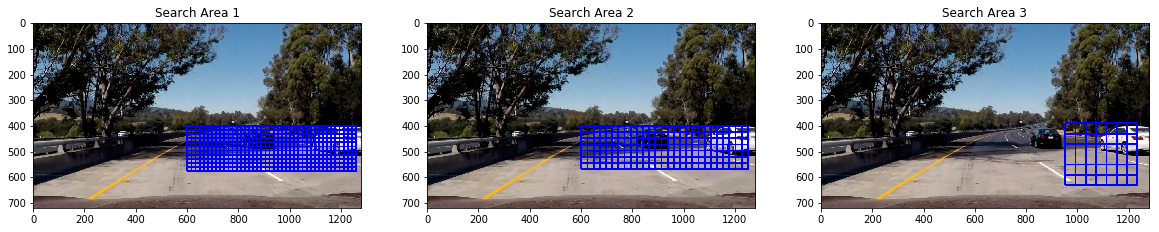

In [54]:
img = snd.imread('test_images/test5.jpg')

area1, _ = detect_cars(img, 400, 600, 600, 1, svc, X_scaler, ORIENT, \
                       PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS, True)
area2, _ = detect_cars(img, 400, 600, 600, 1.5, svc, X_scaler, ORIENT, \
                       PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS, True)
area3, _ = detect_cars(img, 390, 700, 950, 2.5, svc, X_scaler, ORIENT, \
                       PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS, True)

fig = plt.figure(figsize=(20, 8))
plt.subplot(131)
plt.imshow(area1)
plt.title('Search Area 1')
plt.subplot(132)
plt.imshow(area2)
plt.title('Search Area 2')
plt.subplot(133)
plt.imshow(area3)
plt.title('Search Area 3')

My intuition behind search area choosing  was that for far cars detection I need more fined grained sub-samples (low **scale** param) , and for middle and close cars detections I need more coarse grained sub-samples (greater **scale** param).

The example results of car searching using my classifier and sub-sampled window search implementation for test images can be seen below:

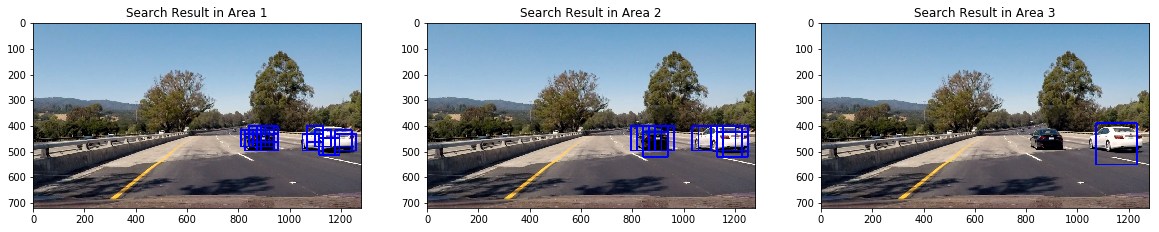

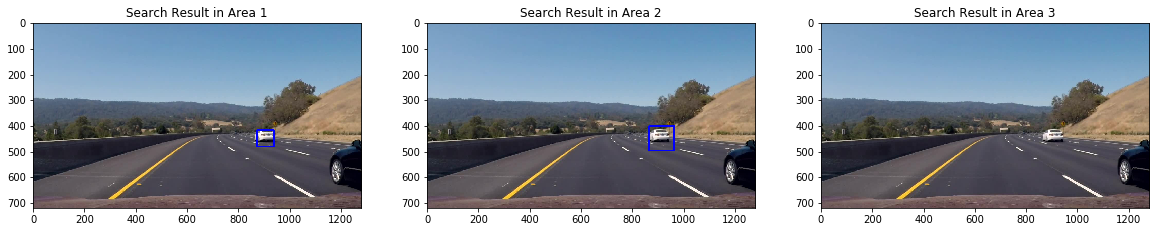

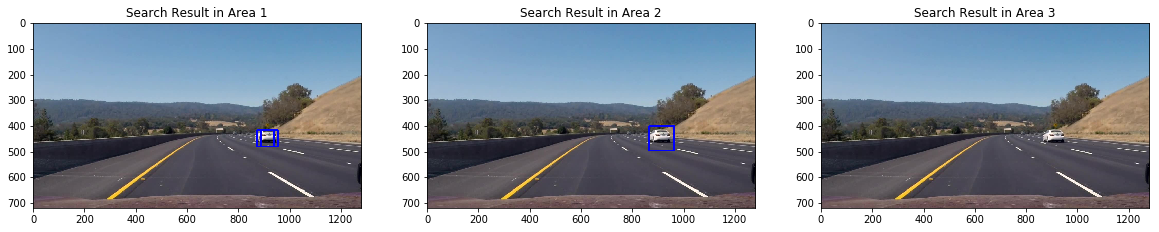

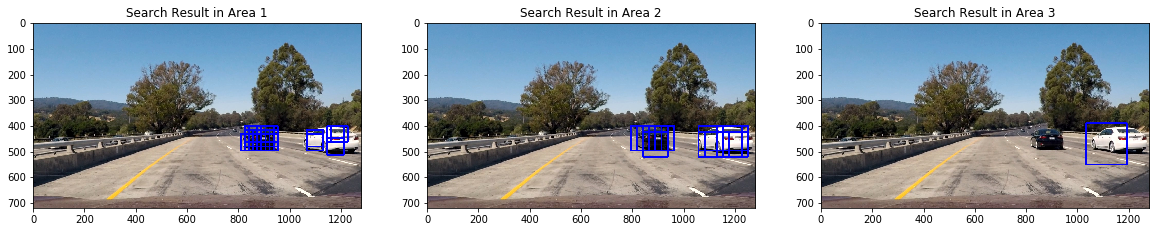

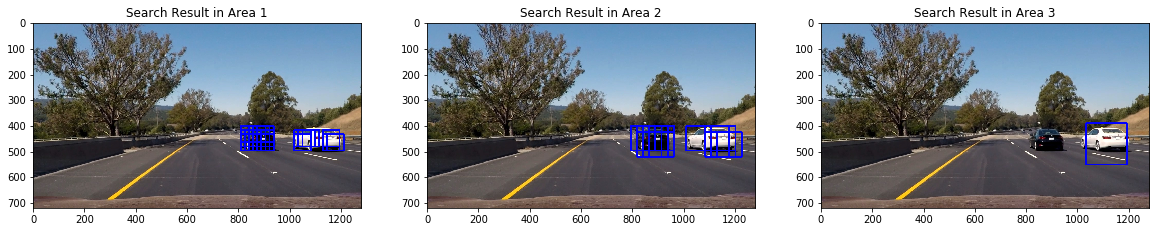

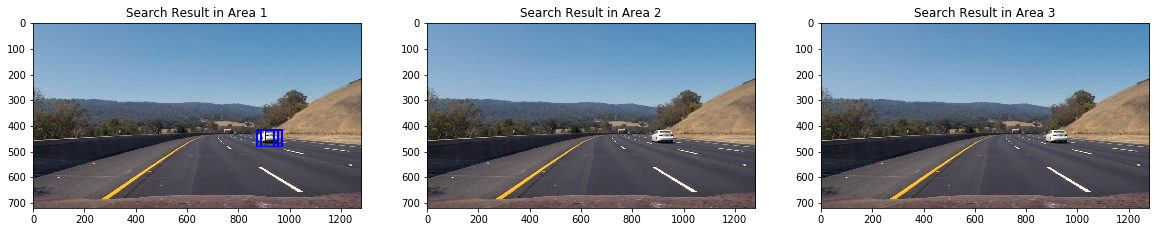

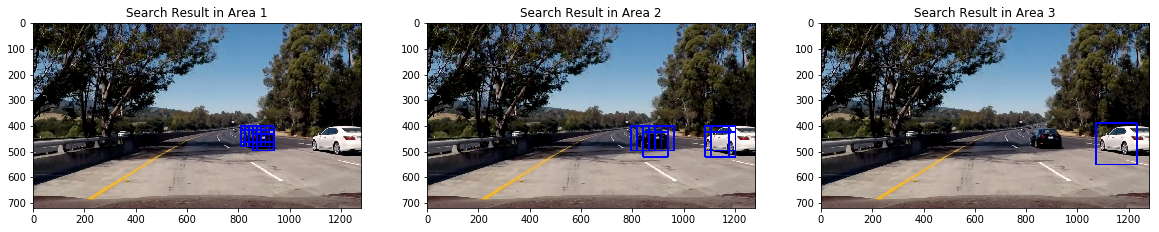

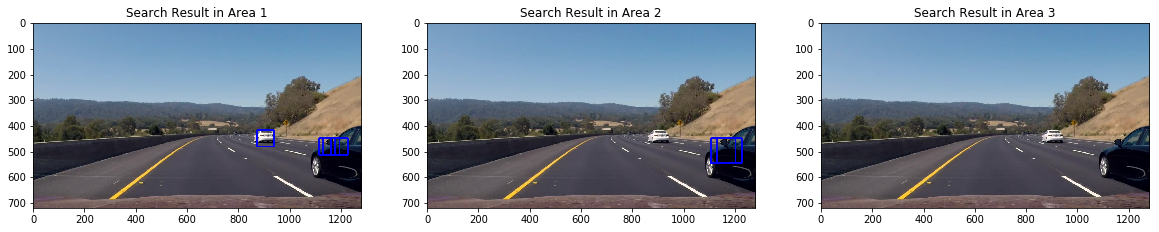

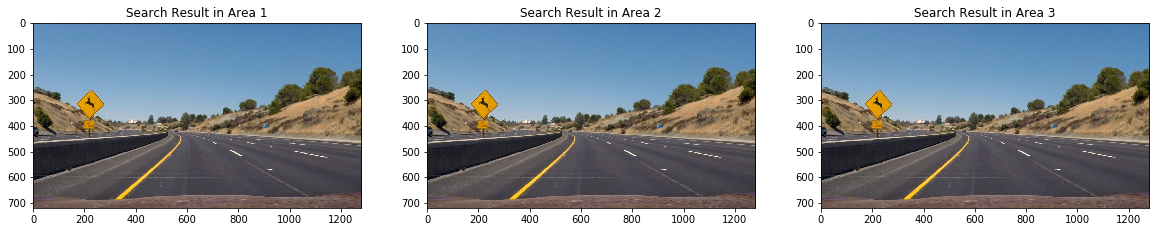

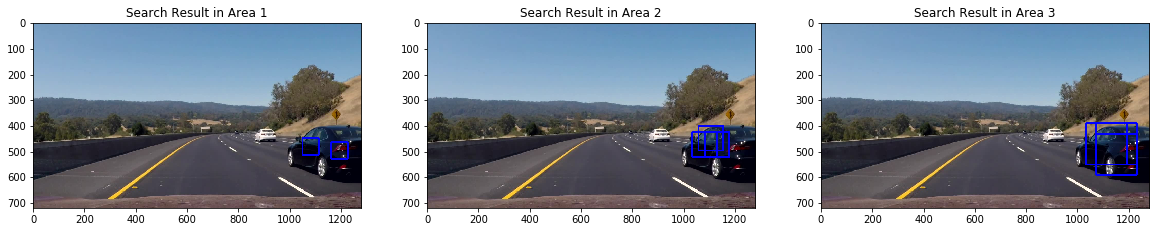

In [52]:
test_files = glob.glob('test_images/*.jpg')

for tf in test_files:
    img = snd.imread(tf)
    area1, bboxes1 = detect_cars(img, 400, 600, 600, 1, svc, X_scaler, ORIENT, \
                           PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS, True)
    area2, bboxes2 = detect_cars(img, 400, 600, 600, 1.5, svc, X_scaler, ORIENT, \
                           PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS, True)
    area3, bboxes3 = detect_cars(img, 390, 700, 950, 2.5, svc, X_scaler, ORIENT, \
                           PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS, True)

    fig = plt.figure(figsize=(20, 8))
    plt.subplot(131)
    plt.imshow(area1)
    plt.title('Search Result in Area 1')
    plt.subplot(132)
    plt.imshow(area2)
    plt.title('Search Result in Area 2')
    plt.subplot(133)
    plt.imshow(area3)
    plt.title('Search Result in Area 3')

### Video Implementation

>**CRITERIA**: Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

In order to reject false positives and to draw bounding boxes around only high-confidence detections where multiple overlapping detections occur I decided to:

* use a buffer of bbox'es with a capacity of 10 frames (smooths results)
* use a heatmap that holds sum of last 10 frames heatmaps
* use threshold of 1 for a heatmap
* use bbox area, width to height ratio, left edge position to detect bbox that is sensible
* use function to draw only sensible labelled bounding boxes

Methods needed to achieve above are following:

In [44]:
BUFFER_MAXLEN = 10
BBOX_BUFFER = deque(maxlen=BUFFER_MAXLEN)
HEATMAP = np.zeros_like(img[:,:,0]).astype(np.float)
THRESH = 1

def add_heat(heatmap, bboxes):
    for box in bboxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def remove_heat(heatmap, bboxes):
    for box in bboxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] -= 1
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def smooth_results(bboxes):
    global BUFFER_MAXLEN, BBOX_BUFFER, HEATMAP
    
    if len(BBOX_BUFFER) == BUFFER_MAXLEN:
        HEATMAP = remove_heat(HEATMAP, BBOX_BUFFER.popleft())
              
    BBOX_BUFFER.append(bboxes)
    HEATMAP = add_heat(HEATMAP, bboxes)
    
    # Apply threshold to help remove false positives
    HEATMAP = apply_threshold(HEATMAP,THRESH)
    HEATMAP = np.clip(HEATMAP, 0, 255)
    
def is_sensible(bbox):
    xwidth = bbox[1][0]-bbox[0][0]
    ywidth = bbox[1][1]-bbox[0][1]
    area = xwidth*ywidth
        
    return area > 250 and xwidth/ywidth >= 0.55 and bbox[0][0] < 1160

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        if is_sensible(bbox):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)

    return img

An example car detection result together with a heatmap that was used to find high confidence detection can be seen below:

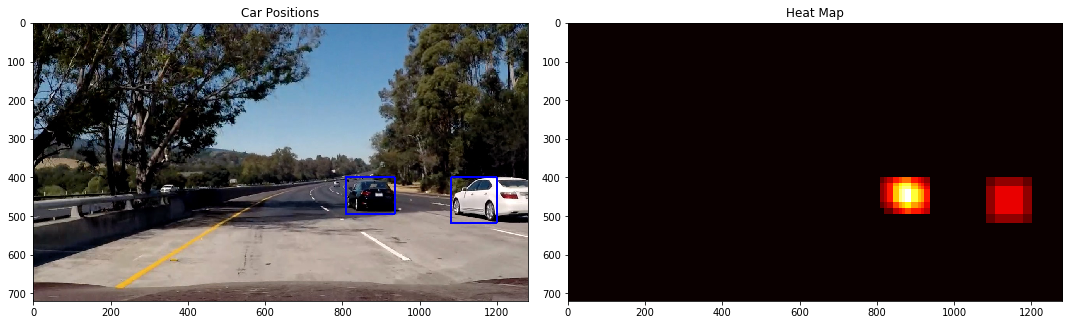

In [64]:
bbox_list = np.concatenate((bb1,bb2,bb3))

heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,bbox_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

Having all that is needed to build a pipeline I prepared one that:

* prepares list of bbox'es predicted by the classifier to hold a car image (from 3 search areas)
* smooths the results and updates the heatmap
* labels the high confidence areas on the heatmap
* draws rectangles around sensible car detections

Code for the pipeline is following:

In [49]:
def process_frame(image): 
    bboxes = []
    bbox_list1 = detect_cars(image, 400, 600, 600, 1, svc, X_scaler,\
                             ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS)
    
    for bbox in bbox_list1:
        bboxes.append(bbox)
    
    bbox_list2 = detect_cars(image, 400, 600, 600, 1.5, svc, X_scaler,\
                             ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS)
    
    for bbox in bbox_list2:
        bboxes.append(bbox)
        
    
    bbox_list3 = detect_cars(image, 390, 700, 950, 2.5, svc, X_scaler,\
                             ORIENT, PIX_PER_CELL, CELL_PER_BLOCK, SPATIAL_SIZE, NBINS)
    
    for bbox in bbox_list3:
        bboxes.append(bbox)
        
    smooth_results(bboxes)
    
    # Find final boxes from heatmap using label function
    labels = label(HEATMAP)
    
    return draw_labeled_bboxes(np.copy(image), labels)

def run(video_file, output_file_name):
    global BBOX_BUFFER
    BBOX_BUFFER.clear()
    video = VideoFileClip(video_file)
    processed_video = video.fl_image(process_frame)
    %time processed_video.write_videofile(output_file_name, audio=False)

In [50]:
video_file = 'project_video.mp4'
output_file_name = 'output_video.mp4'

run(video_file, output_file_name)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [13:40<00:00,  1.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

CPU times: user 15min 11s, sys: 4.5 s, total: 15min 16s
Wall time: 13min 41s


>**CRITERIA**: Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file_name))

### Discussion

>**CRITERIA:** Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

Problems faced:

* the classifier is not able to generalize good based on the provided training data. I mean that having the same pipeline and false positive detection mechanism and the same test split (0.2) two classifiers can have different
accuracy (highly depend on which images wen to train and which to test split)

Where will your pipeline likely fail?:
* I had to tune search areas to detected those two cars from video. Even a slight change in scale factor had
an inpact on whether a particular car was detected or not (detected when far away but not detected when in the middle, etc.) so I guess that this pipeline can have troubles when a different configuration of car color/shape/distance happens
* as every algorithm depending on visual aspects of the world around it will probably fail in a bad weather conditions (rain, snow)

What could you do to make it more robust?:

* train on more data
* to make it more robust we could combine this approach with LIDAR detections
* use deep learning for the search
* rewrite in c++, python version is too slow for real time processing